In [1]:
from datasets import load_dataset

train_ds = load_dataset("imagefolder", data_dir="audio_transformer/data/train", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/8733 [00:00<?, ?it/s]

Using custom data configuration default-056bb73702904399
Reusing dataset image_folder (/home/ubuntu/.cache/huggingface/datasets/image_folder/default-056bb73702904399/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


5500 2620 612


In [2]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [3]:
import json

with open('audio_transformer/data/label2id.json') as f:
    label2id = json.load(f)

with open('audio_transformer/data/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [17]:
from transformers import DeiTFeatureExtractor

feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
#  model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")


https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /home/ubuntu/.cache/huggingface/transformers/tmpytstgn21


Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

storing https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/preprocessor_config.json in cache at /home/ubuntu/.cache/huggingface/transformers/a3c9a583827005951a2f3c81e5d6f3bda9f52700892e2acb36110a8b5a26ef1b.29240c085a2cf1c33c4279bd14ec75a73811c11a5873eab1f004bde6fe6309f7
creating metadata file for /home/ubuntu/.cache/huggingface/transformers/a3c9a583827005951a2f3c81e5d6f3bda9f52700892e2acb36110a8b5a26ef1b.29240c085a2cf1c33c4279bd14ec75a73811c11a5873eab1f004bde6fe6309f7
loading feature extractor configuration file https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/preprocessor_config.json from cache at /home/ubuntu/.cache/huggingface/transformers/a3c9a583827005951a2f3c81e5d6f3bda9f52700892e2acb36110a8b5a26ef1b.29240c085a2cf1c33c4279bd14ec75a73811c11a5873eab1f004bde6fe6309f7
Feature extractor DeiTFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DeiT

In [5]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [6]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [7]:
train_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7EFD949DF4E0>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7EFD949DF470>],
 'classID': [7, 3],
 'class': ['jackhammer', 'dog_bark'],
 'pixel_values': [tensor([[[ 1.1187,  1.1187,  1.1187,  ...,  1.0673,  0.7077,  0.7077],
           [ 1.0844,  1.0844,  1.0844,  ...,  1.0331,  0.7248,  0.7248],
           [ 0.9303,  0.9303,  0.9303,  ...,  0.8618,  0.8104,  0.8104],
           ...,
           [ 2.1119,  2.1119,  2.1119,  ...,  2.1804,  2.0948,  2.0948],
           [ 2.1119,  2.1119,  2.1119,  ...,  2.2147,  2.1633,  2.1633],
           [ 2.1119,  2.1119,  2.1119,  ...,  2.2147,  2.1633,  2.1633]],
  
          [[-1.0378, -1.0378, -1.0378,  ..., -1.0553, -1.1779, -1.1779],
           [-1.0553, -1.0553, -1.0553,  ..., -1.0728, -1.1779, -1.1779],
           [-1.1078, -1.1078, -1.1078,  ..., -1.1253, -1.1429, -1.1429],
           ...,
           [-0.0399, -0.0399, -0.0399,  ...,  0.4678,  

In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [18]:
from transformers import DeiTForImageClassification
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224",
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  ignore_mismatched_sizes=True)

https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/ubuntu/.cache/huggingface/transformers/tmp66s4h8fp


Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/config.json in cache at /home/ubuntu/.cache/huggingface/transformers/714ee60a09194779d2acdbf17d75f0cca867f496a85550c69b29fd6f66c8b4fa.a46ddd6a2d7a28e819ee5dfa80b7ccfbcb74b937148567c84d918781d35b3721
creating metadata file for /home/ubuntu/.cache/huggingface/transformers/714ee60a09194779d2acdbf17d75f0cca867f496a85550c69b29fd6f66c8b4fa.a46ddd6a2d7a28e819ee5dfa80b7ccfbcb74b937148567c84d918781d35b3721
loading configuration file https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/config.json from cache at /home/ubuntu/.cache/huggingface/transformers/714ee60a09194779d2acdbf17d75f0cca867f496a85550c69b29fd6f66c8b4fa.a46ddd6a2d7a28e819ee5dfa80b7ccfbcb74b937148567c84d918781d35b3721
Model config DeiTConfig {
  "architectures": [
    "DeiTForImageClassificationWithTeacher"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0

Downloading:   0%|          | 0.00/333M [00:00<?, ?B/s]

storing https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/pytorch_model.bin in cache at /home/ubuntu/.cache/huggingface/transformers/4bd4c7588647eabacf363ecf61f5285633607d10e315048b47ca4bc5b9742f49.89cf9afdd85db0db778890939fde24ed5f60ce453af494c4f12946c6b3efda91
creating metadata file for /home/ubuntu/.cache/huggingface/transformers/4bd4c7588647eabacf363ecf61f5285633607d10e315048b47ca4bc5b9742f49.89cf9afdd85db0db778890939fde24ed5f60ce453af494c4f12946c6b3efda91
loading weights file https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/pytorch_model.bin from cache at /home/ubuntu/.cache/huggingface/transformers/4bd4c7588647eabacf363ecf61f5285633607d10e315048b47ca4bc5b9742f49.89cf9afdd85db0db778890939fde24ed5f60ce453af494c4f12946c6b3efda91
Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.bias', 'distillation_classifier.weight', 'cls

In [19]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [20]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [21]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [14]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

In [22]:
trainer.train()

/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5500
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2750


Epoch,Training Loss,Validation Loss,Accuracy
1,0.954500,0.466000,0.841503
2,0.569900,0.275393,0.908497
3,0.452800,0.233814,0.919935
4,0.378800,0.164148,0.947712
5,0.320400,0.150808,0.950980


***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-550
Configuration saved in test-cifar-10/checkpoint-550/config.json
Model weights saved in test-cifar-10/checkpoint-550/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-550/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1100
Configuration saved in test-cifar-10/checkpoint-1100/config.json
Model weights saved in test-cifar-10/checkpoint-1100/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-1100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1650
Configuration saved in test-cifar-10/checkpoint-1650/config.json
Model weights saved in test-cifar-10/checkpoint-1650/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-16

TrainOutput(global_step=2750, training_loss=0.5126709400523792, metrics={'train_runtime': 4356.6678, 'train_samples_per_second': 6.312, 'train_steps_per_second': 0.631, 'total_flos': 2.13122066217984e+18, 'train_loss': 0.5126709400523792, 'epoch': 5.0})

In [23]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2620
  Batch size = 4


In [24]:
print(outputs.metrics)

{'test_loss': 0.1805463284254074, 'test_accuracy': 0.9427480916030534, 'test_runtime': 144.4759, 'test_samples_per_second': 18.135, 'test_steps_per_second': 4.534}


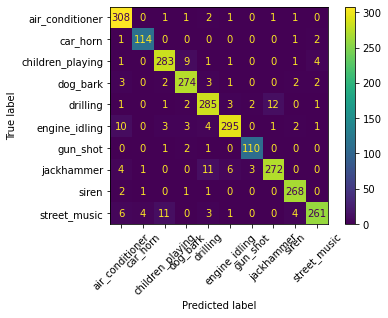

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [26]:
model.save_pretrained("/home/ubuntu/models/AudioDeiT")

Configuration saved in /home/ubuntu/models/AudioDeiT/config.json
Model weights saved in /home/ubuntu/models/AudioDeiT/pytorch_model.bin
